This notebook shows some simple examples of what all the other notebooks do. 

## Libraries

In [34]:
import requests
import csv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import spearmanr
import pickle
import time

%run EncodingDataset.ipynb

## 1) Concept similarity using encoded vectors.

Once the HDvectors are encoded, we can now simply use these vectors to compare similarity betwen pairs of words. Here is a list of pairs and its similarity according to SimLex-999.
 
- 'physician' - 'doctor'     (8.88)
- 'dentist' - 'colonel'      (0.40)
- 'lens' - 'camera'          (4.28)
- 'president' - 'mayor'      (5.68)
- 'president' - 'politician' (7.38)
- 'orthodontist' - 'dentist' (8.27)

The "Dict.pkl" file can be downloaded [here](https://1drv.ms/u/s!AkCN44HxsE59gqFYpFnYBwTIaANThQ?e=7K8xTl)

In [16]:
# Importing vectors
Dict = pickle.load( open("Dict.pkl", "rb"))

In [17]:
# Distance function
def HD_simm(concept1, concept2):
    "Measures semantic similarity"
    return (1 - ( float(HDvector.dist(Dict[concept1].getPointer(), Dict[concept2].getPointer())) - 2800 ) / (5000 - 2800)) * 10 

In [18]:
print("dentist - colonel: ", HD_simm('dentist','colonel'))
print("president - mayor: ", HD_simm('president','mayor'))
print ("lens - camera: ", HD_simm('lens','camera'))
print ("president - politician: ", HD_simm('president','politician'))
print ("physician - doctor: ", HD_simm('physician','doctor'))
print ("orthodontist - dentist: ", HD_simm('sofa','chair'))

dentist - colonel:  0.21363636363636362
president - mayor:  3.5
lens - camera:  4.481818181818182
president - politician:  4.6045454545454545
physician - doctor:  7.804545454545455
orthodontist - dentist:  5.763636363636364


## 2) Representing concepts

Here we show the entire process to get the representations vectors for the pair "sofa" - "chair". *SimLex sim 6.67; our model: 5.76*

Many process were simplified to make this explanation simpler.

### Relations

Edges to explore from ConceptNet

In [19]:
Concepts = ['sofa','chair']
Relations = ['IsA','UsedFor','AtLocation']

In [20]:
def clean_term (string):
    "Cleans up a word from: /c/en/loyal_friend to loyal_friend"
    A = string[string.rfind('/')+1:]
    try: 
        return str(A)
    except:
        return []

### Requesting loop

In [21]:
max_num_feat = 30 #Max features
max_feats_per_relation = 10 # Max features per relations

All_sem_features = []  # Array

# Loop for requesting edges from ConceptNet graph
for Concept in Concepts:
    #Creating list of URLs
    URL_start = 'http://api.conceptnet.io/query?start='
    URL_concept = '/c/en/' + Concept
    URL_relation = '&rel=/r/'
    URL_filter = '&filter=/c/en'
    URLs = [URL_start + URL_concept + URL_relation + r + URL_filter for r in Relations]
    Sem_features = []
    for URL in URLs:
        # Pause to avoid errors..
        time.sleep(2.1)
        # Requesting edges
        response = requests.get(URL)
        obj = response.json()
        edges = obj['edges']
        # List of features for relations:
        L_rel = []
        i = 0
        for edge in edges:
            c_name = edge['start']['term']
            rel = edge['rel']['label']
            o_name = edge['end']['term']
            w = edge['weight']
            if o_name[:6] != '/c/en/':  # Filtering non-english concepts
                break
    
            # Creating tuple: [concept, name + POS, relation, object, weight] "('" + clean_term(c_name) + "' 'N')"
            L_rel.append([clean_term(c_name), str(rel), clean_term(o_name), [clean_term(o_name)], w, 0])
            i += 1

            # Condition for max number of features
            if i > max_feats_per_relation: 
                break
                
        # Sorting assertions by weight 
        L_rel.sort(key = lambda x: x[4], reverse = True)
        # Keeping only the 'num_feat' more important features
        Sem_features.append(L_rel[:max_num_feat])
        
    Final_feats = []
    # Cleaning and sorting features...
    for l in Sem_features:
        if len(l) > 0:
            Final_feats.extend(l)
    Final_feats.sort(key = lambda x : x[4], reverse = True)
    All_sem_features.append(Final_feats[:10])

#### First 10 features for sofa

In [22]:
print('Features for sofa')
for f in All_sem_features[0]:
    print (f)

Features for sofa
['sofa', 'IsA', 'piece_of_furniture', ['piece_of_furniture'], 3.4641016151377544, 0]
['sofa', 'UsedFor', 'relax', ['relax'], 2.82842712474619, 0]
['sofa', 'UsedFor', 'lounging', ['lounging'], 2.82842712474619, 0]
['sofa', 'UsedFor', 'lying_on', ['lying_on'], 2.82842712474619, 0]
['sofa', 'UsedFor', 'sleeping', ['sleeping'], 2.82842712474619, 0]
['sofa', 'AtLocation', 'house', ['house'], 2.82842712474619, 0]
['sofa', 'IsA', 'seat', ['seat'], 2.0, 0]
['sofa', 'IsA', 'place_to_sit', ['place_to_sit'], 2.0, 0]
['sofa', 'IsA', 'chair', ['chair'], 2.0, 0]
['sofa', 'IsA', 'comfortable_place_to_sit', ['comfortable_place_to_sit'], 2.0, 0]


#### First 10 features for chair

In [23]:
# First 10 features for chair
print('Features for chair')
for f in All_sem_features[1]:
    print(f)

Features for chair
['chair', 'AtLocation', 'office', ['office'], 8.48528137423857, 0]
['chair', 'AtLocation', 'desk', ['desk'], 6.6332495807108, 0]
['chair', 'UsedFor', 'resting', ['resting'], 3.4641016151377544, 0]
['chair', 'AtLocation', 'cubicle', ['cubicle'], 3.4641016151377544, 0]
['chair', 'AtLocation', 'porch', ['porch'], 3.4641016151377544, 0]
['chair', 'AtLocation', 'living_room', ['living_room'], 2.82842712474619, 0]
['chair', 'AtLocation', 'room', ['room'], 2.82842712474619, 0]
['chair', 'AtLocation', 'church', ['church'], 2.82842712474619, 0]
['chair', 'AtLocation', 'kitchen', ['kitchen'], 2.82842712474619, 0]
['chair', 'IsA', 'seat', ['seat'], 2.0, 0]


### Encoding as HDvectors

In [35]:
Init_mem(Concepts, All_sem_features, 2) 

Begining to encode dataset...
End of encoding


### Measuring Distance
This distance value is only considering a few relations, and without doing any clustering process

In [36]:
print("Hamming distance sofa - chair: ", (1 - ( float(HDvector.dist(Dict['sofa'].getPointer(), Dict['chair'].getPointer())) - 2800 ) / (5000 - 2800)) * 10 )

Hamming distance sofa - chair:  1.8454545454545457


## 3) Example of feature clustering

The following example takes the features for the relation "AtLocation" for the pair *sofa-chair*

In [41]:
# Feature values (from the concept 'bed' in Samples)
Features = ['office', 'desk', 'porch','cubicle', 'living_room', 'kitchen','room', 'church', 'house']

Features = np.array( list( map(lambda x: np.array([x]), Features) ) )

Features

array([['office'],
       ['desk'],
       ['porch'],
       ['cubicle'],
       ['living_room'],
       ['kitchen'],
       ['room'],
       ['church'],
       ['house']], dtype='<U11')

### Distance function

In [38]:
def conceptnet_dist(w1, w2):
    URL_start = 'http://api.conceptnet.io/relatedness?node1=/c/en/'
    URL_middle = '&node2=/c/en/'
    # Generating URL
    URL = URL_start + w1[0] + URL_middle + w2[0]
    # Requesting JSON
    response = requests.get(URL)
    obj = response.json()
    time.sleep(2.1)
    print(w1, w2)
    return 1 - obj['value']

### Pairwise distances

In [43]:
from scipy.spatial.distance import pdist

X = pdist(Features, metric=conceptnet_dist) # This can take a while...

['office'] ['desk']
['office'] ['porch']
['office'] ['cubicle']
['office'] ['living_room']
['office'] ['kitchen']
['office'] ['room']
['office'] ['church']
['office'] ['house']
['desk'] ['porch']
['desk'] ['cubicle']
['desk'] ['living_room']
['desk'] ['kitchen']
['desk'] ['room']
['desk'] ['church']
['desk'] ['house']
['porch'] ['cubicle']
['porch'] ['living_room']
['porch'] ['kitchen']
['porch'] ['room']
['porch'] ['church']
['porch'] ['house']
['cubicle'] ['living_room']
['cubicle'] ['kitchen']
['cubicle'] ['room']
['cubicle'] ['church']
['cubicle'] ['house']
['living_room'] ['kitchen']
['living_room'] ['room']
['living_room'] ['church']
['living_room'] ['house']
['kitchen'] ['room']
['kitchen'] ['church']
['kitchen'] ['house']
['room'] ['church']
['room'] ['house']
['church'] ['house']


### Clustering

This cell shows tha final dendrogram from which new vectors for the feautues would be assigned (this time not orthogonal)

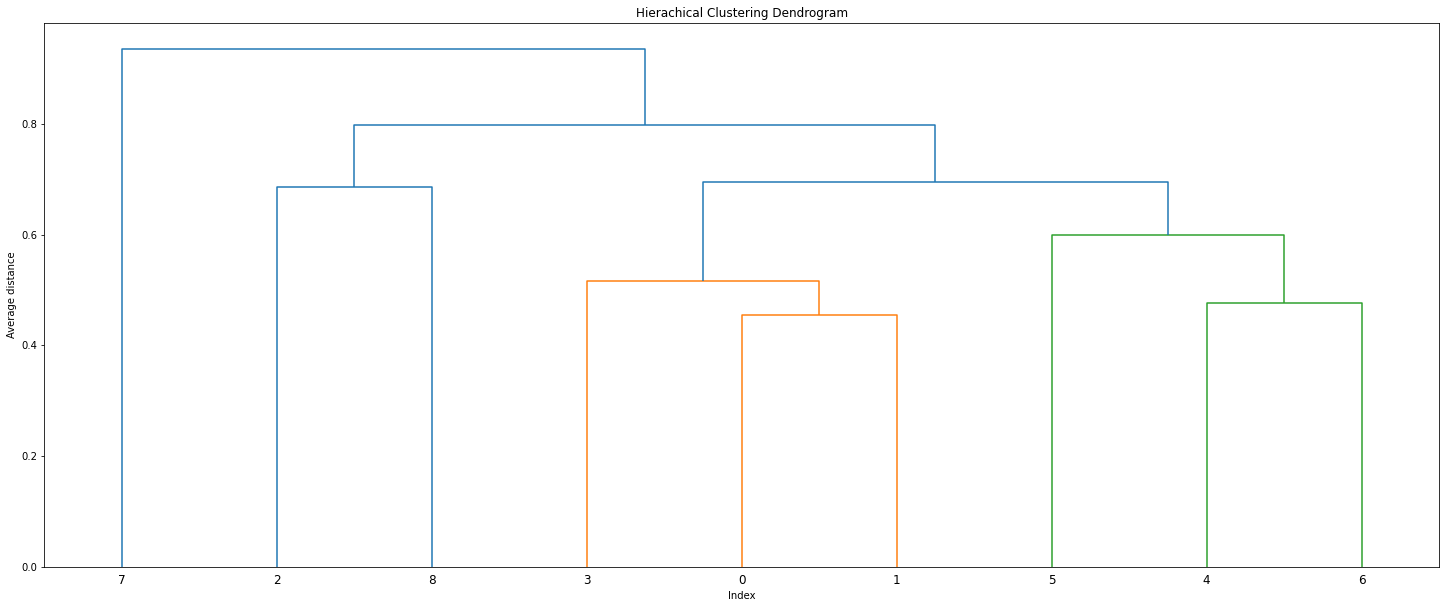

In [44]:
from scipy.cluster.hierarchy import linkage, dendrogram

distance = linkage(X, 'average')

plt.figure(figsize=(25,10))
plt.title("Hierachical Clustering Dendrogram")
plt.xlabel("Index")
plt.ylabel("Average distance")
dn = dendrogram(distance)

In [45]:
print("Feature 7:", Features[7][0])
print ("Features (3,0,1): (", Features[3][0] + ',', Features[0][0] +',' , Features[1][0], ')')
print ("Features (5,4,6): (", Features[5][0] + ',', Features[4][0] +',' , Features[6][0], ')')
print ("Features (2,8): (", Features[2][0] + ',', Features[8][0], ')')

# These features will be assigned closer, rather than orthogonal vectors.

Feature 7: church
Features (3,0,1): ( cubicle, office, desk )
Features (5,4,6): ( kitchen, living_room, room )
Features (2,8): ( porch, house )
